In [1]:
import pandas as pd                                                                                                                                                              
import numpy as np                                                                                                                                                               
import wfdb                                                                                                                                                                      
import ast, sys
from tqdm import tqdm
tqdm.pandas()  
sys.path.append("/home/moritz/repositories/med_leak/")                                                                                                                                                            

In [2]:
def load_raw_data(df, sampling_rate, path):                                                                                                                                      
    if sampling_rate == 100:                                                                                                                                                     
        data = [wfdb.rdsamp(path+f) for f in tqdm(df.filename_lr)]                                                                                                                     
    else:                                                                                                                                                                        
        data = [wfdb.rdsamp(path+f) for f in tqdm(df.filename_hr)]                                                                                                                     
    data = np.array([signal for signal, meta in data])                                                                                                                           
    return data                                                                                                                                                                  
                                                                                                                                                                                 
path = '/home/moritz/data/physionet.org/files/ptb-xl/1.0.3/'
sampling_rate = 100            

# load and convert annotation data                                                                                                                                               
df = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')                                                                                                                   
df.scp_codes = df.scp_codes.apply(lambda x: ast.literal_eval(x))
                                                                                                                                                                               
# Load raw signal data                                                                                                                                                           
X = load_raw_data(df, sampling_rate, path)                                                                                                                                      

100%|██████████| 21799/21799 [00:40<00:00, 543.16it/s]


In [3]:
np.mean(X), np.std(X), np.min(X), np.max(X)

(-0.0007808800556600472, 0.23539237334110466, -20.032, 17.212)

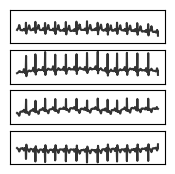

In [4]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 6, 'figure.figsize': (2, 2)})
sample = X[5]
xrange = np.arange(sample.shape[0])
fig, axs = plt.subplots(4, 1, sharex=True, sharey=True)
for i, ax in zip(range(12), axs.flat):
    ax.plot(xrange, sample[:, i], label=i, color='black', alpha=0.8)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()


In [5]:
# prepare binary columns for the five superclasses
df["NORM"] = 0
df["MI"] = 0
df["STTC"] = 0
df["CD"] = 0
df["HYP"] = 0

In [6]:
# Load scp_statements.csv for diagnostic aggregation                                                                                                                             
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)                                                                                                                     
agg_df = agg_df[agg_df.diagnostic == 1]      

In [7]:
# aggregate diagnoses into superclasses with a lookup into agg_df
def aggregate_diagnostic(row):
    for key in row.scp_codes.keys():                                                                                                                                                     
        if key in agg_df.index:                                                                                                                                                  
            respective_superclass = str(agg_df.loc[key].diagnostic_class)
            if respective_superclass[0] == '[':
                respective_superclass = ast.literal_eval(respective_superclass)[0]
            row[respective_superclass] = 1
    return row

In [8]:
# Apply diagnostic superclass                                                                                                                                                    
df = df.progress_apply(aggregate_diagnostic, axis=1)

100%|██████████| 21799/21799 [00:02<00:00, 8658.31it/s] 


In [9]:
df.CD.value_counts(dropna=False), df.HYP.value_counts(dropna=False), df.MI.value_counts(dropna=False), df.NORM.value_counts(dropna=False), df.STTC.value_counts(dropna=False)

(CD
 0    16901
 1     4898
 Name: count, dtype: int64,
 HYP
 0    19150
 1     2649
 Name: count, dtype: int64,
 MI
 0    16330
 1     5469
 Name: count, dtype: int64,
 NORM
 0    12285
 1     9514
 Name: count, dtype: int64,
 STTC
 0    16564
 1     5235
 Name: count, dtype: int64)

In [10]:
# official train-test split
test_fold = 10
# inputs
X_train = X[np.where(df.strat_fold != test_fold)]
X_test = X[np.where(df.strat_fold == test_fold)]
# targets
train_df = df[(df.strat_fold != test_fold)]
test_df = df[(df.strat_fold == test_fold)]

In [11]:
train_df = train_df.reset_index()
test_df = test_df.reset_index()
assert len(X_train) == len(train_df)
assert len(X_test) == len(test_df)
len(train_df), len(test_df)

(19601, 2198)

In [12]:
train_df

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,NORM,MI,STTC,CD,HYP
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,1,0,0,0,0
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,1,0,0,0,0
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,1,0,0,0,0
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,1,0,0,0,0
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19596,21833,17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,...,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr,0,0,1,0,0
19597,21834,20703.0,300.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,...,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr,1,0,0,0,0
19598,21835,19311.0,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-08 10:30:27,...,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr,0,0,1,0,0
19599,21836,8873.0,64.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-09 18:21:49,...,SVES,NaN,8,records100/21000/21836_lr,records500/21000/21836_hr,1,0,0,0,0


In [13]:
#train_df.to_csv("/home/moritz/repositories/med_leak/data/csv/ptb-xl_train.csv")
#test_df.to_csv("/home/moritz/repositories/med_leak/data/csv/ptb-xl_test.csv")

In [14]:
#np.save(f"{path}X_{sampling_rate}_train.npy", X_train)
#np.save(f"{path}X_{sampling_rate}_test.npy", X_test)

### Cohort Table

In [15]:
from utils import cohort_table
from src.data_utils.constants import ECG_LABELS_LONG, ECG_LABELS
df["sex"] = df["sex"].replace({0: 'Female', 1: 'Male'})
df["Extra Systole"] = "No"
df.loc[df.extra_beats.isna() == False, "Extra Systole"] = "Yes"
df["Extra Systole"].value_counts()

Extra Systole
No     19850
Yes     1949
Name: count, dtype: int64

In [16]:
cohort_df = cohort_table(df, strat_var="sex", strat_var_vals=["Female", "Male"], other_vars=["Extra Systole"]+ECG_LABELS, patient_id_col="patient_id")
# keep only rows where diagnostic label was present (value 1.0)
cohort_df = cohort_df.loc[np.logical_not(cohort_df.Variable == "0 (\%)")]
string_labels = [f"{a} (\%)" for a in  ECG_LABELS_LONG]
cohort_df.iloc[-len(ECG_LABELS): ,cohort_df.columns.get_loc('Variable')] = string_labels
cohort_df

OrderedDict([('Variable', ['Patients', 'Records', 'Median age (SD)']), ('All', ['18869', '21799', '62 (32)']), ('Female', ['9640', '11354', '61 (24)']), ('Male', ['9229', '10445', '64 (39)'])])


,Variable,All,Female,Male
0,Patients,18869,9640,9229
1,Records,21799,11354,10445
2,Median age (SD),62 (32),61 (24),64 (39)
3,No (\%),19850 (91.1),10227 (90.1),9623 (92.1)
4,Yes (\%),1949 (8.9),1127 (9.9),822 (7.9)
5,Normal (\%),9514 (43.6),4386 (38.6),5128 (49.1)
8,myocardial infarction (\%),5469 (25.1),3407 (30.0),2062 (19.7)
10,ST/T-changes (\%),5235 (24.0),2566 (22.6),2669 (25.6)
12,conduction disturbance (\%),4898 (22.5),2999 (26.4),1899 (18.2)
14,hypertrophy (\%),2649 (12.2),1520 (13.4),1129 (10.8)


In [17]:
cohort_df.to_latex("./tables/ptb-xl.tex", index=False)